# Part 1/2: Query in nuScenes Dataset: Visualize LiDAR point clouds for a single instance

Reference Medium post: https://medium.com/@msayef/query-in-nuscenes-dataset-visualize-lidar-point-clouds-for-a-single-instance-541ce496bb0d

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.axes import Axes
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import rc, animation
from matplotlib import animation
from IPython.display import HTML


from nuscenes.nuscenes import NuScenes
from nuscenes import NuScenesExplorer
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import BoxVisibility

import numpy as np

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='../data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.306 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


There are 23 different categories of objects. Let’s see what are those:

In [3]:
for category in nusc.category:
    print(category['name'])

human.pedestrian.adult
human.pedestrian.child
human.pedestrian.wheelchair
human.pedestrian.stroller
human.pedestrian.personal_mobility
human.pedestrian.police_officer
human.pedestrian.construction_worker
animal
vehicle.car
vehicle.motorcycle
vehicle.bicycle
vehicle.bus.bendy
vehicle.bus.rigid
vehicle.truck
vehicle.construction
vehicle.emergency.ambulance
vehicle.emergency.police
vehicle.trailer
movable_object.barrier
movable_object.trafficcone
movable_object.pushable_pullable
movable_object.debris
static_object.bicycle_rack


Let’s pick vehicle.car as our potential target instance. We can list all the instances with this category first. The following piece of code provides a list of instances those belong to vehicle.car category.

In [4]:
vehicles = []
for i in range(len(nusc.instance)):
    instance = nusc.instance[i]
    category = nusc.get('category', instance['category_token'])
    if 'vehicle.car' in category['name']:
        vehicles.append(i)

In nuScenes dataset, there are a total of 12 sensors. We can have a look at the sensor list using the following code snippet.

In [5]:
for sensor in nusc.sensor:
    print(sensor['channel'])

CAM_FRONT
CAM_BACK
CAM_BACK_LEFT
CAM_FRONT_LEFT
CAM_FRONT_RIGHT
CAM_BACK_RIGHT
LIDAR_TOP
RADAR_FRONT
RADAR_FRONT_RIGHT
RADAR_FRONT_LEFT
RADAR_BACK_LEFT
RADAR_BACK_RIGHT


For the sake of easy visualization, let’s consider only those instances that can be seen from the front camera only.

In [6]:
def belongs_to(anntoken, expected_cam='CAM_FRONT'):
    boxes = []
    ann_record = nusc.get('sample_annotation', anntoken)
    sample_record = nusc.get('sample', ann_record['sample_token'])
    _, boxes, _ = nusc.get_sample_data(sample_record['data'][expected_cam], box_vis_level=BoxVisibility.ANY,
                                                                                            selected_anntokens=[anntoken])

    if len(boxes) == 1:    
            return True
    return False

cam_front_vehicles = []

for i in vehicles:
    instance = nusc.instance[i]
    ann_token = instance['first_annotation_token']
    if belongs_to(ann_token):
        cam_front_vehicles.append(i)

We have missed one thing important, that the previous code snippet can only filter the instances which can be seen from the front camera only in the first frame of the whole tracking time. To ensure that the instances are seen from the front camera the whole time, we need to apply the following filter further.

In [7]:
print('Instance IDs: ')

for i in cam_front_vehicles:
    instance = nusc.instance[i]
    first_token = instance['first_annotation_token']
    last_token = instance['last_annotation_token']
    current_token = first_token

    flag = True
    while current_token != last_token:
        if not belongs_to(current_token):
            flag = False
            break
        current_ann = nusc.get('sample_annotation', current_token)
        current_token = current_ann['next']

    if flag:
        print(i, end=' ')

Instance IDs: 
74 153 154 234 250 256 258 262 265 270 272 284 291 295 296 306 338 344 392 400 500 508 552 591 595 624 679 687 754 758 762 766 775 822 857 892 902 

We loop through the tokens from the first annotation token to the last annotation token to retrieve in-between annotation tokens and check whether they were captured from the front camera.

Let’s write some utility codes which will be helpful for later parts. First, we define a function fig2np which will convert a Matplotlib figure to NumPy array.

In [8]:
def fig2np(fig):
    '''
    Converts matplotlib figure to numpy array
    '''
    canvas = FigureCanvas(fig)
    width, height = fig.get_size_inches() * fig.get_dpi()
    canvas.draw()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    return image

We will now write code for rendering 3D LIDAR data to the 2D plane by using some built-in functions of nuScenes. We will return NumPy array of the rendered Matplotlib figure. The code is self-explanatory, although I used the necessary comments.

In [9]:
def lidar2d(ann_token):
    '''
    Combines bounding box of instance and LIDAR 2D data and returns numpy array of the rendered figure and the box center.
    '''

    # We retrieve annotation record associated with this annotation token
    ann_record = nusc.get('sample_annotation', ann_token)

    # Now, retrieve sample record associated with the sample token of ann_token
    sample_record = nusc.get('sample', ann_record['sample_token'])

    # Now, we get LIDAR metadata from sample_record['data']['LIDAR_TOP'] and
    # retrieve binary file path of LIDAR data using nusc.get_sample_data()
    # We can also pass annotation tokens to visualize instances. 
    # In our case, we have only one instance to visualize.
    lidar = sample_record['data']['LIDAR_TOP']
    data_path, boxes, _ = nusc.get_sample_data(lidar, selected_anntokens=[ann_token])

    # Declare matplotlib figure and axes for visualization
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # We now send data_path to retrieve 3D LIDAR data, but we want to project
    # that onto 2D plane. render_height can in-built function of LidarPointCloud
    # does the job for us, we just need to pass data_path and matplotlib axis.
    LidarPointCloud.from_file(data_path).render_height(ax)
    
    # Let's just draw the instace boxes over the renderd LIDAR data.
    for box in boxes:
        c = np.array(nusc.explorer.get_color(box.name)) / 255.0
        box.render(ax, colors=(c, c, c))
    
    # prevent drawing axes
    plt.axis('off')

    # stop drawing
    %matplotlib agg

    # convert matplotlib figure to numpy array
    img = fig2np(fig)

    return img, box.center

We can now choose one of our desired instances for visualization. Let’s take instance index 153. We store all the images (as in NumPy array) in a list imgs.

In [10]:
def generate_images_for_animation(instance_id):
    instance = nusc.instance[instance_id]
    first_token = instance['first_annotation_token']
    last_token = instance['last_annotation_token']
    current_token = first_token
 
    imgs = []
    centers = []
    
    while current_token != last_token:
        current_ann = nusc.get('sample_annotation', current_token)
        img, center = lidar2d(current_ann['token'])
        imgs.append(img)
        centers.append(center)

        current_token = current_ann['next']
    return imgs, centers

imgs, centers = generate_images_for_animation(153)

Now that we have all our rendered images of instance index 153, we can animate the frames using the following code snippet.

In [13]:
def init():
    img.set_data(imgs[0])
    return (img,)

def animate(i):
    img.set_data(imgs[i])
    return (img,)

fig = plt.figure(figsize=(9,9))
ax = fig.gca()
img = ax.imshow(imgs[0])
anim = animation.FuncAnimation(fig, animate, init_func=init,
                                                         frames=len(imgs), interval=500, blit=True)

anim.save('lidar.gif', writer='pillow', fps=10)

# Part 2/2: Ground Detection and Removal from Point Clouds

Reference Medium post: https://medium.com/@msayef/ground-detection-and-removal-from-point-clouds-8f3ce1fd6eaa

Let’s choose a file from this directory samples/LIDAR_TOP. We can get point clouds using LidarPointCloud.from_file the built-in method.

In [3]:
lidar_point_cloud = LidarPointCloud.from_file("../data/sets/nuscenes/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928698048.pcd.bin")
data = np.swapaxes(lidar_point_cloud.points, 0, 1)[:,:3]
print(data.shape)

(34720, 3)


We can render these points as we did last time using render_height() method.

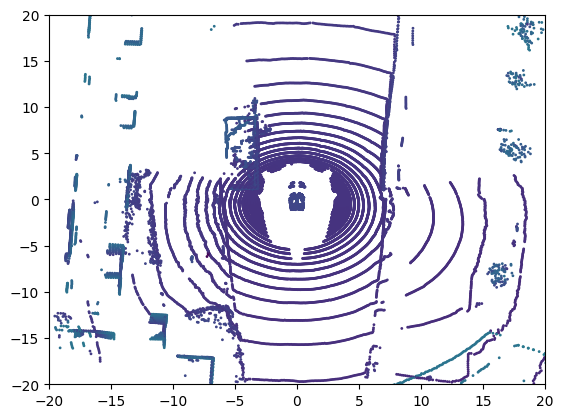

In [4]:
%matplotlib inline
lidar_point_cloud.render_height(plt.gca())

Let’s say we don’t know which column corresponds to height or conventionally z-axis. We assume that the ground points have the low in z coordinate values. We will find the variances column-wise and see which column has the lowest variance, as we saw that most of the points belong to the ground.

In [5]:
z_idx = int(np.argmin(np.var(data, axis = 0)))
print(z_idx)

2


That means the 3rd axis is the z-axis.

Create a new column for the index, we will need that for removing or processing the column values.

In [19]:
data = np.append(data, np.arange(data.shape[0]).reshape(-1, 1), axis=1)

Now, find the mean and standard deviation of the height column. Filter out all the points which are within 1.5 standard deviations from the mean.

In [6]:
data_z = data[:,z_idx]
mean = np.mean(data_z)
sd = np.std(data_z)
data_ground = data[(data_z < mean + 1.5 * sd) & (data_z > mean - 1.5 * sd)]
data_wo_ground= np.delete(data, data_ground[:,3].astype(int), axis=0)[:,:3]

As we have got ground-free point clouds, we can put it back to lidar_point_cloud.points and render it in a 2D plane as a Matplotlib figure.

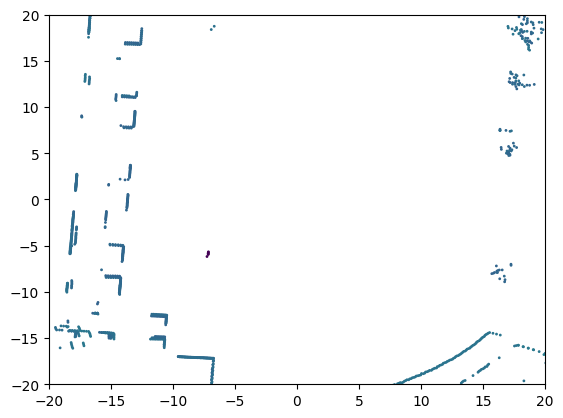

In [7]:
lidar_point_cloud.points = np.swapaxes(data_wo_ground, 0, 1)
lidar_point_cloud.render_height(plt.gca())

Voilà! We just removed ground points based on the assumption on height. But the approach is a little aggressive as it removed some other points which belong to some important objects, which we can see comparing the previous two plots. For example, the car itself has vanished, and a big rectangular shaped object to the upper left corner of the car has also vanished. We can try tweaking the height threshold range to fix this. However, we are going to show a robust approach toward outliers detection, as in separating non-ground points that were detected as ground earlier. In other words, these outliers are not ground points and we should not remove them.

We have ground points in data_ground variable. Before processing any further, let's scale the height column based on the minimum and maximum values.

In [8]:
max_z, min_z = np.max(data_ground[:, z_idx]), np.min(data_ground[:, z_idx])
data_ground[:, z_idx] = (data_ground[:, z_idx] - min_z)/(max_z - min_z)

We can get back the original scale using reverse formula. Don’t need to worry about that now.

Now, we will find the covariance matrix, which somewhat represent the linear relationship among axes. Let’s say we have m data points and n = 3 axes. The shape of the covariance matrix would be 3x3.

In [9]:
covariance = np.cov(data_ground[:, :3].T)

There is a theorem called eigen-decompistion that allows us to determine the structure of a system of linear equations. In the context of data analysis, it is often used to identify patterns and trends in data. When we perform eigen-decomposition on a dataset, we are essentially trying to find the “principal axes” of the data, which are the directions along which the data varies the most.

The sum of the projections of the data onto these principal axes is maximized by eigen-decomposition. Eigenvalues, on the other hand, are used to measure the importance or “variance” of each principal axis. In other words, eigenvalues tell us how much each principal axis contributes to the overall variability of the data.

By using eigen-decomposition to transform the data into a new coordinate system, we can more easily see how much each axis contributes to the overall variability of the data. This process is known as Principal Component Analysis (PCA). Other than explaining variability of data, PCA is a useful technique for identifying patterns and trends in data and for reducing the dimensionality of the data, which can make it easier to visualize and analyze.

In [10]:
eigen_values, eigen_vectors =  np.linalg.eig(np.matrix(covariance))

Normally, we take the argmax of the eigenvalues to find the first principal component (i.e., eigenvector). Since we want to remove outliers, it's better to find the last principal component which least explains the variability.

In [11]:
normal_vector = eigen_vectors[np.argmin(eigen_values)]

So far, we have our m data points and a vector which is nothing but an axis in a different coordinate system. Let's project our m points to that vector. The projection will be a single value for each point, as we took only one vector. So, the output is of m*1 shape.

In [12]:
projection = normal_vector.dot(data_ground[:, :3].T)

To eliminate the outliers, we couldn’t decide from 3D points which one should be removed. Since we have only one point for decision now, we can easily choose a threshold. As eigenvectors are unit vector and projection lies between -1 to 1, one can try different threshold from 0 to 1 on the absolute value of projection. In our case, I experimented a little and found 0.4 is good to go. So, we declare all the values less than that are inliers and greater than that are outliers. Think it as the distance towards regular points, which in our case ground. So it should be as close to zero to be considered as inliers.

In [13]:
ground_mask = np.abs(projection) < 0.4
data_ground = np.asarray([data_ground[index[1]] for index, a in np.ndenumerate(ground_mask) if a == True])

Interestingly, we have only inliers in data_ground which we can filter again and again for better ground detection with a for-loop. But for now, just stick with one iteration of this process. We aren’t done yet. We scaled the height column, which we must transform back to the previous scale.

In [14]:
data_ground[:, z_idx] = data_ground[:, z_idx] * (max_z - min_z) + min_z


Now, remove ground points from the LIDAR data and render to see the difference.

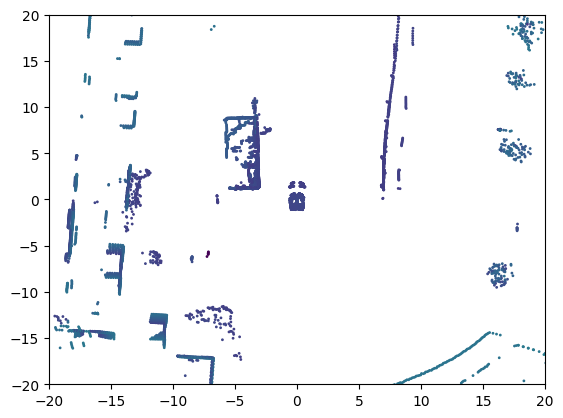

In [15]:
world = np.delete(data, data_ground[:,3].astype(int), axis=0)[:,:3]
lidar_point_cloud.points = np.swapaxes(world, 0, 1)
lidar_point_cloud.render_height(plt.gca())

That’s it! We just improved our naive approach with the PCA outlier removal technique.

If we closely look at the LIDAR point clouds, it’s clear that ground points are on a plane, we don’t know the height of the plane or the angle if the road is steep. But we can find that plane based on a few assumptions. The algorithm we will be approaching now is called random sample consensus, abbreviated RANSAC. The key idea is very simple. For line detection, two points are randomly chosen and scored based on some estimation/model and check if how many inliers are there.

In the example plot, it’s noticeable that the blue line is a better fit than the black one.

We do this over and over by sampling randomly and check the conditions if they apply, save the best result. Likewise, for the plane fitting, we can sample 3 or more points from the data since a plane can be made of a minimum of 3 points. The scoring model I am going to use here is almost like PCA, which I am not going to explain here because it’s out of the scope of this article. The concept is well explained [here](http://www.cs.tau.ac.il/~turkel/imagepapers/RANSAC4Dummies.pdf). You can have a visit there.

Let’s write utility functions for our RANSAC algorithm and feed our point clouds. RANSAC code courtesy: [falcondai/py-ransac](https://github.com/falcondai/py-ransac).

In [16]:
import random

def ransac(data, model, is_inlier, sample_size, max_iterations, goal_inliers, random_seed=75, debug=False):
    best_ic = 0
    best_model = None
    random.seed(random_seed)

    data = list(data)
    for i in range(max_iterations):
        s = random.sample(data, int(sample_size))
        m = model(s)
        ic = 0
        for j in range(len(data)):
              if is_inlier(m, data[j]):
                      ic += 1

        if debug:
              print('Coeffs:', m, '# inliers:', ic)

        if ic > best_ic:
            best_ic = ic
            best_model = m
            if goal_inliers and ic > goal_inliers:
                  break
    if debug: 
          print('Took iterations:', i+1, 'Best model coeffs:', best_model, 'Inliers covered:', best_ic)

    return best_model, best_ic

def augment(xyzs):
    axyz = np.ones((len(xyzs), 4))
    axyz[:, :3] = xyzs
    return axyz

def model(xyzs):
    axyz = augment(xyzs[:3])
    return np.linalg.svd(axyz)[-1][-1, :]

def is_inlier(coeffs, xyz, threshold):
    return np.abs(coeffs.dot(augment([xyz]).T)) < threshold

Let’s set the parameters of the ransac function and see how it works.

In [17]:
# maximum number of iterations
max_iterations = 50
# number of points we want to sample, 3 is minimum, but we can choose more for better fitting.
sample_size = 10
# distance threshold for choosing inliers
threshold = 0.15
# minimum numbers of inliers we need to have, we can ignore this parameter by setting None
goal_inliers = data.shape[0] * 0.2

coeff, _ = ransac(data[:, :3], model, lambda x, y: is_inlier(x, y, threshold), sample_size, max_iterations, goal_inliers)
proj = data[:,0] * coeff[0] + data[:,1] * coeff[1] + data[:,2] * coeff[2] + coeff[3]

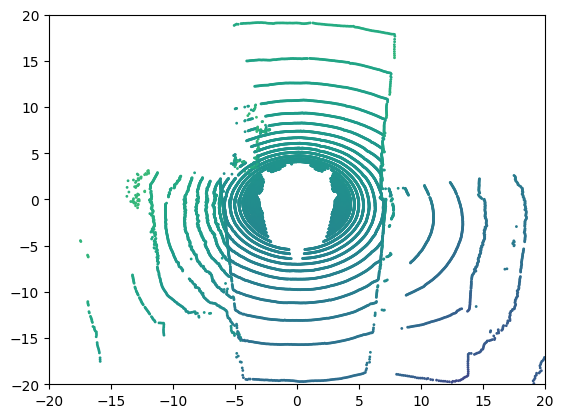

In [18]:
# display detected ground point clouds
lidar_point_cloud.points = np.swapaxes(data[np.abs(proj) <= threshold], 0, 1)
lidar_point_cloud.render_height(plt.gca())

We have separated the ground and non-ground point clouds, which looks pretty cool, right?

We have discussed and implemented 3 different approaches to detecting and removing the ground from point clouds. We started with thresholding in height range. Then we showed how to improve using the PCA outliers removal process and RANSAC plane fitting algorithm. There are plenty of other algorithms to deal with ground detection. It’s still an ongoing research topic. In our next post, we will implement Kalman-filter for tracking an object, given that we can detect the instance from time to time.